# Financial Distress Prediction using ML, GNN & Causal-GNN

## Objective
Mục tiêu của bài nghiên cứu:
- Xây dựng baseline **Machine Learning (ML)** để dự đoán distress.
- Tạo cấu trúc graph dựa trên:  
  - sector relationships  
  - cosine similarity  
  - merged graph  
- Huấn luyện các mô hình **GNN** gồm:  
  - GCN  
  - GraphSAGE  
  - GAT  
- Tránh data leakage bằng split theo năm.
- Kết hợp **Causal Reasoning** để thử nghiệm các dạng đồ thị:
  1. Baseline similarity graph  
  2. Self-loop causal graph  
  3. Similarity + causal sector prior  
- Tối ưu tham số của ML và GNN bằng grid search.

---

## Workflow tổng quan

1. Load & tiền xử lý dữ liệu  
2. Chọn feature & tạo ma trận đặc trưng  
3. Phân tích EDA  
4. Split theo thời gian (temporal split)  
5. Train ML + threshold tuning  
6. Xây dựng graph (sector, similarity, merged)  
7. Train GNN  
8. Causal graph ablation  
9. GNN grid search  
10. Leaderboard

---


## 1. Import Libraries & Setup

Ở phần này, ta sẽ:
- Import các thư viện ML, DL, và Graph.
- Cài đặt seed để đảm bảo reproducibility.
- Kiểm tra thiết bị (GPU/CPU).

Đây là bước chuẩn bị cần thiết để đảm bảo mọi thực nghiệm ổn định và tái lập được.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix,
    precision_recall_curve
)

from imblearn.ensemble import BalancedBaggingClassifier

# GNN + graph
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
import torch.nn.functional as F_torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv




c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Seeding & Device Setup

GNN/ML thường có randomness:
- weight initialization  
- randomness trong batch  
- dropout  
- graph sampling  

Vì thế cần cố định seed để:
- đảm bảo tái lập kết quả
- dễ so sánh giữa các mô hình


In [2]:
# ============================================================
# 0) SEED
# ============================================================
def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", device)

DEVICE: cpu


## 3. Load Dataset

Ta tải dataset đã được tiền xử lý.  
Sau đó:

### Step:
- ép kiểu cột `year`
- thống kê số dòng và tỉ lệ distress
- kiểm tra phân phối label

### Các bước này giúp:
- đánh giá mức độ imbalance  
- đánh giá mức độ ổn định theo năm  
- kiểm tra dữ liệu đã sạch chưa  


In [4]:
# ============================================================
# 1) Load PROCESSED file
# ============================================================
df_full = pd.read_csv("C:/Users/HP/Downloads/Seminar/nasdaq100_preprocessed_clean.csv")
df_full["year"] = df_full["year"].astype(int)

print("\n[DATA]")
print("shape:", df_full.shape)

print(df_full["y_distress"].value_counts())

print("\ny_distress rate:", df_full["y_distress"].mean().round(4))


[DATA]
shape: (567, 45)
y_distress
0    496
1     71
Name: count, dtype: int64

y_distress rate: 0.1252


## 4. Feature Engineering

### Logic xử lý:
Loại bỏ các cột không phải feature:
- thông tin định danh: symbol, company  
- thông tin phân nhóm: sector, subsector  
- nhãn: y, y_distress  
- timestamp: year  

### Mục tiêu:
Tạo ra matrix `X` với numeric features duy nhất để:
- chạy ML baseline  
- dùng làm node features cho GNN

In [5]:
# ============================================================
# 2) Feature matrix (IDENTICAL to GNN)
# ============================================================
exclude = {"symbol", "company", "sector", "subsector", "year", "zscore", "y", "y_distress"}
feature_cols = [c for c in df_full.columns if c not in exclude]

X = (
    df_full[feature_cols]
    .apply(pd.to_numeric, errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .values.astype(np.float32)
)
y = df_full["y_distress"].values.astype(int)

print("\n[FEATURES]")
print("num_features:", len(feature_cols))


[FEATURES]
num_features: 40


# 5. Exploratory Data Analysis (EDA)


[EDA] Target distribution (normalize):
y_distress
0    0.87478
1    0.12522
Name: proportion, dtype: float64


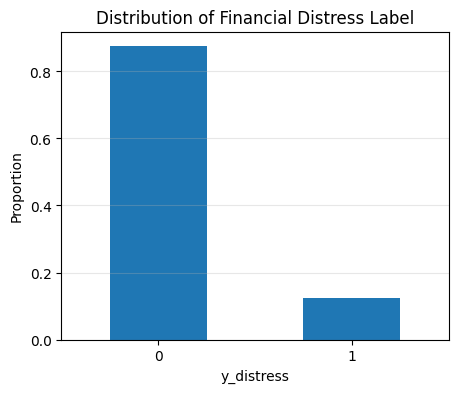

In [104]:
# -----------------------------
# TARGET EXPLORATION (Phân phối biến mục tiêu)
# -----------------------------
print("\n[EDA] Target distribution (normalize):")
print(df_full["y_distress"].value_counts(normalize=True))

distress_rate = df_full["y_distress"].value_counts(normalize=True)

plt.figure(figsize=(5,4))
distress_rate.plot(kind="bar")
plt.ylabel("Proportion")
plt.title("Distribution of Financial Distress Label")
plt.xticks(rotation=0)
plt.grid(True, axis="y", alpha=0.3)
plt.show()

### Insight
Biểu đồ cho thấy dữ liệu bị **mất cân bằng nghiêm trọng** (imbalanced).  
Tỷ lệ distress (label = 1) chỉ chiếm khoảng **10–15%**, trong khi non-distress chiếm hơn **85–90%**.

=>
- Cần xử lý imbalance (ví dụ: pos_weight, BalancedBagging trong ML, hoặc BCEWithLogitsLoss + pos_weight trong GNN).
- Accuracy không còn là metric phù hợp → dùng PR-AUC & F1.
- Threshold mặc định 0.5 sẽ không hiệu quả → phải tune threshold trên Validation.


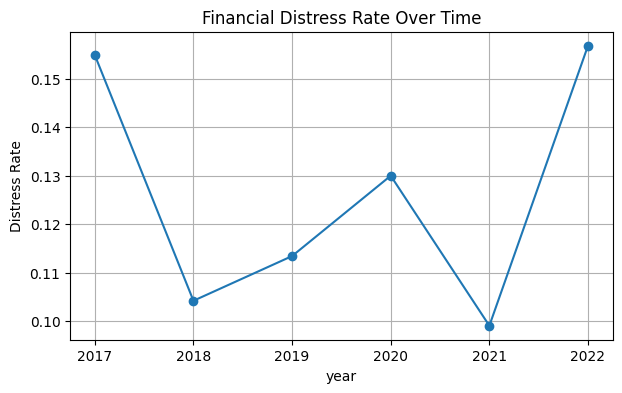

In [105]:
# -----------------------------
# Distress by year
# -----------------------------
distress_by_year = df_full.groupby("year")["y_distress"].mean()

plt.figure(figsize=(7,4))
distress_by_year.plot(marker="o")
plt.ylabel("Distress Rate")
plt.title("Financial Distress Rate Over Time")
plt.grid(True)
plt.show()

### Insight
Nhận xét:
- Mức distress có dao động rõ rệt theo từng năm.

=>
- Dữ liệu **có tính thời gian (temporal)** → không thể shuffle ngẫu nhiên.
- Train/Val/Test phải chia theo năm để tránh **leakage** (quá khứ → tương lai).


[EDA] Số lượng features: 40


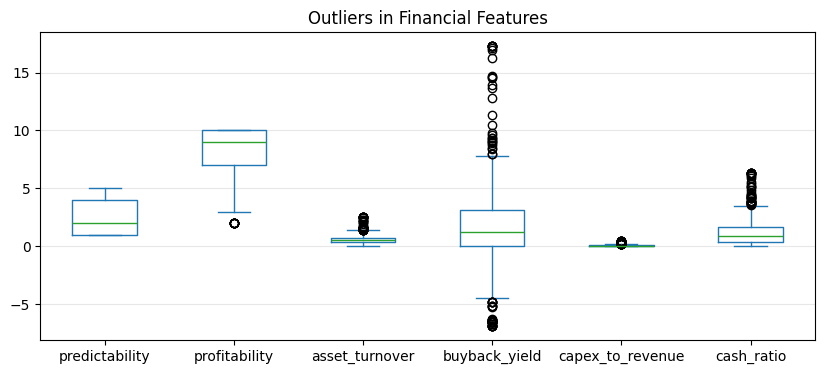

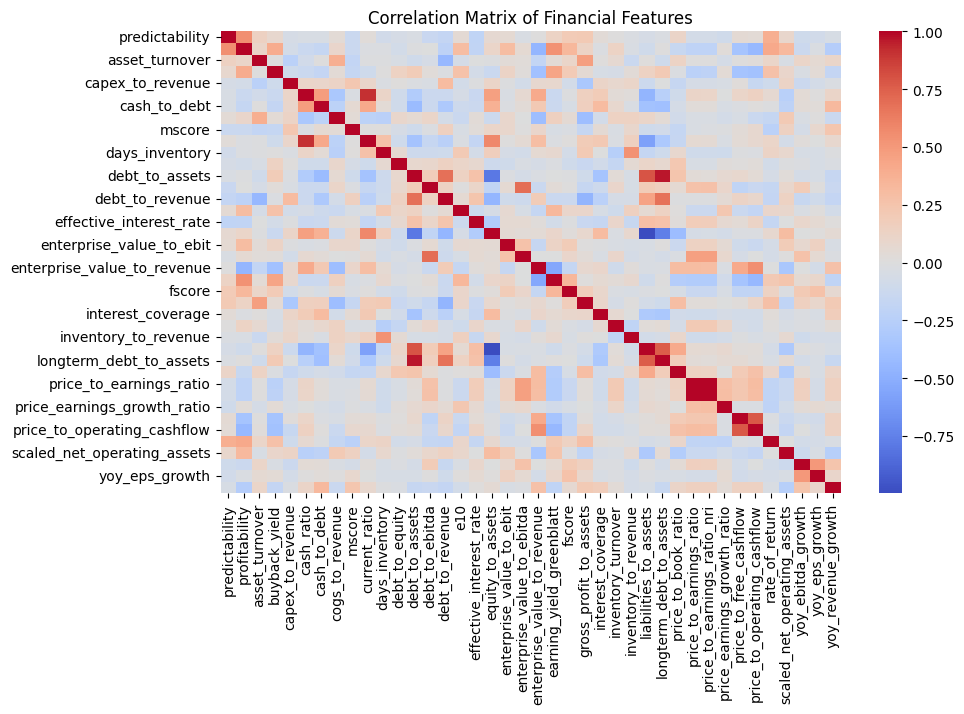

In [106]:
# -----------------------------
# PHÂN PHỐI FEATURE (OUTLIER & SCALE CHECK)
# -----------------------------
print("\n[EDA] Số lượng features:", len(feature_cols))

df_full[feature_cols[:6]].plot(kind="box", figsize=(10,4))
plt.title("Outliers in Financial Features")
plt.grid(True, axis="y", alpha=0.3)
plt.show()

corr = df_full[feature_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar=True)
plt.title("Correlation Matrix of Financial Features")
plt.show()

- Financial ratios tự nhiên có outliers do nhiều công ty có tăng trưởng đột biến hoặc lỗ lớn.
- GNN/ML rất nhạy cảm với outliers → cần chuẩn hóa

## 6. Split Data

### Cách chia tập:
- **Train**: 2017 → 2020  
- **Validation**: 2021  
- **Test**: 2022

Do dữ liệu có thứ tự thời gian (time series theo năm), không được phép shuffle hoặc chia ngẫu nhiên

In [6]:
# ============================================================
# 4) Time-based split
# ============================================================
train_idx = df_full["year"] <= 2020
val_idx   = df_full["year"] == 2021
test_idx  = df_full["year"] == 2022

Xtr, ytr = X[train_idx], y[train_idx]
Xval, yval = X[val_idx], y[val_idx]
Xte, yte = X[test_idx], y[test_idx]

print("\n[SPLIT]")
print("Train:", Xtr.shape, "Val:", Xval.shape, "Test:", Xte.shape)
print("Train distress rate:", ytr.mean().round(4))
print("Val distress rate  :", yval.mean().round(4))
print("Test distress rate :", yte.mean().round(4))


[SPLIT]
Train: (364, 40) Val: (101, 40) Test: (102, 40)
Train distress rate: 0.1236
Val distress rate  : 0.099
Test distress rate : 0.1569


## 7. Machine Learning Baseline Models

Các model bao gồm:
- Logistic Regression  
- SVM (RBF)  
- Decision Tree  
- Random Forest  
- Gradient Boosting  
- Balanced Bagging (kết hợp bootstrap + balanced sampling)

### Chiến lược đánh giá
1. Fit model bằng **Train**
2. Dự đoán **Validation**
3. Chọn threshold để tối ưu **F1 trên Validation**
4. Chọn hyperparameter với **best PR-AUC**
5. Test trên **Test 2022** với threshold đã chọn

In [108]:
# ============================================================
# 5) ML: Threshold tuning + MODEL-SPECIFIC hyperparam optimization (on VAL)
#    - Fit on train (<=2020)
#    - Select hyperparams by Val PR-AUC (tie-break by Val F1@best-threshold)
#    - Tune threshold on Val
#    - Evaluate on Test
# ============================================================

def tune_threshold_f1(y_true, y_proba):
    p, r, thr = precision_recall_curve(y_true, y_proba)
    f1 = 2 * p * r / (p + r + 1e-12)
    idx = np.argmax(f1[:-1])  # ignore last
    return float(thr[idx]), float(f1[idx])

def eval_at_threshold(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    return {
        "Precision": precision_score(y_true, pred, zero_division=0),
        "Recall": recall_score(y_true, pred, zero_division=0),
        "F1": f1_score(y_true, pred, zero_division=0),
        "PR-AUC": average_precision_score(y_true, proba),
        "Accuracy": acc,
        "CM": confusion_matrix(y_true, pred)
    }

def grid_search_ml(model_builder, grid, name):
    """
    Manual grid:
      - Fit on train
      - Get val proba
      - compute val PR-AUC
      - tune threshold for best val F1
      - pick best by val PR-AUC, then val F1
    """
    best = None
    best_model = None

    for params in grid:
        model = model_builder(params)
        model.fit(Xtr, ytr)

        proba_val = model.predict_proba(Xval)[:, 1]
        val_ap = average_precision_score(yval, proba_val)
        thr, val_f1 = tune_threshold_f1(yval, proba_val)

        cand = {"params": params, "val_PR-AUC": val_ap, "thr": thr, "val_F1": val_f1}

        if best is None:
            best, best_model = cand, model
        else:
            if (cand["val_PR-AUC"] > best["val_PR-AUC"] + 1e-12) or (
                abs(cand["val_PR-AUC"] - best["val_PR-AUC"]) <= 1e-12 and cand["val_F1"] > best["val_F1"] + 1e-12
            ):
                best, best_model = cand, model

    # refit best model on train
    best_model = model_builder(best["params"])
    best_model.fit(Xtr, ytr)

    print(f"\n[ML OPT] {name}")
    print("Best params:", best["params"])
    print(f"Val PR-AUC={best['val_PR-AUC']:.4f} | Val bestF1={best['val_F1']:.4f} | thr={best['thr']:.3f}")
    return best_model, best

## 8. Define ML Models and Hyperparameter Grids


### Các tham số:
- LR: tune C  
- SVM RBF: tune C & gamma  
- Tree-based: max_depth, min_samples_leaf  
- RF/GBDT: n_estimators, max_depth, learning_rate  
- BalancedBagging: số lượng estimator  

### Lưu ý:
- Tất cả các mô hình ML đều được scale bằng RobustScaler (trừ tree-based)
- Các model Logistic/SVM/BB có class_weight hoặc sampling để xử lý imbalance


In [109]:
# -----------------------------
# ML builders + grids (MODEL-SPECIFIC)
# -----------------------------
def build_lr(p):
    return Pipeline([
        ("scaler", RobustScaler()),
        ("clf", LogisticRegression(
            max_iter=5000,
            class_weight="balanced",
            C=p.get("C", 1.0),
            solver="lbfgs"
        ))
    ])

lr_grid = [{"C": c} for c in [0.25, 0.5, 1.0, 2.0, 4.0]]

def build_svc(p):
    return Pipeline([
        ("scaler", RobustScaler()),
        ("clf", SVC(
            kernel="rbf",
            C=p.get("C", 2.0),
            gamma=p.get("gamma", "scale"),
            class_weight="balanced",
            probability=True
        ))
    ])

svc_grid = [{"C": c, "gamma": g} for c in [0.5, 1.0, 2.0, 4.0] for g in ["scale", "auto"]]

def build_dt(p):
    return DecisionTreeClassifier(
        max_depth=p.get("max_depth", 6),
        min_samples_leaf=p.get("min_samples_leaf", 20),
        class_weight="balanced",
        random_state=42
    )

dt_grid = [
    {"max_depth": d, "min_samples_leaf": l}
    for d in [4, 6, 8, None]
    for l in [5, 10, 20]
]

def build_rf(p):
    return RandomForestClassifier(
        n_estimators=p.get("n_estimators", 600),
        min_samples_leaf=p.get("min_samples_leaf", 10),
        max_depth=p.get("max_depth", None),
        max_features=p.get("max_features", "sqrt"),
        class_weight="balanced_subsample",
        random_state=42,
        n_jobs=-1
    )

rf_grid = [
    {"n_estimators": n, "min_samples_leaf": l, "max_depth": d, "max_features": mf}
    for n in [300, 600, 900]
    for l in [5, 10, 20]
    for d in [None, 8, 16]
    for mf in ["sqrt", "log2"]
]

def build_gbdt(p):
    return GradientBoostingClassifier(
        n_estimators=p.get("n_estimators", 400),
        learning_rate=p.get("learning_rate", 0.05),
        max_depth=p.get("max_depth", 3),
        subsample=p.get("subsample", 0.8),
        random_state=42
    )

gbdt_grid = [
    {"n_estimators": n, "learning_rate": lr, "max_depth": d, "subsample": ss}
    for n in [200, 400, 600]
    for lr in [0.03, 0.05, 0.08]
    for d in [2, 3, 4]
    for ss in [0.7, 0.8, 1.0]
]

def build_bb(p):
    base = DecisionTreeClassifier(
        max_depth=p.get("max_depth", 6),
        min_samples_leaf=p.get("min_samples_leaf", 10),
        random_state=42
    )
    # imblearn version compatibility
    try:
        return BalancedBaggingClassifier(
            estimator=base,
            n_estimators=p.get("n_estimators", 300),
            random_state=42,
            n_jobs=-1
        )
    except TypeError:
        return BalancedBaggingClassifier(
            base_estimator=base,
            n_estimators=p.get("n_estimators", 300),
            random_state=42,
            n_jobs=-1
        )

bb_grid = [
    {"n_estimators": n, "max_depth": d, "min_samples_leaf": l}
    for n in [150, 300, 450]
    for d in [4, 6, 8]
    for l in [5, 10, 20]
]

ml_specs = [
    ("Logistic Regression", build_lr, lr_grid),
    ("SVC (RBF)", build_svc, svc_grid),
    ("Decision Tree", build_dt, dt_grid),
    ("Random Forest", build_rf, rf_grid),
    ("Gradient Boosting", build_gbdt, gbdt_grid),
    ("Balanced Bagging", build_bb, bb_grid),
]

In [110]:
# -----------------------------
# Run ML optimization
# -----------------------------
ml_results = []
best_ml_models = {}

print("\n============================================================")
print("ML: optimize hyperparams on VAL + tune threshold on VAL")
print("============================================================")

for name, builder, grid in ml_specs:
    model, best = grid_search_ml(builder, grid, name)

    # proba on test
    proba_test = model.predict_proba(Xte)[:, 1]
    test_metrics = eval_at_threshold(yte, proba_test, best["thr"])

    print(f"Test Precision={test_metrics['Precision']:.4f} | Recall={test_metrics['Recall']:.4f} | F1={test_metrics['F1']:.4f} | PR-AUC={test_metrics['PR-AUC']:.4f}")
    print("Confusion matrix (TEST):\n", test_metrics["CM"])

    best_ml_models[name] = model
    ml_results.append({
        "Model": name,
        "Type": "ML",
        "Threshold": best["thr"],
        "Val_PR-AUC": best["val_PR-AUC"],
        "Val_F1@thr": best["val_F1"],
        "Precision": test_metrics["Precision"],
        "Recall": test_metrics["Recall"],
        "F1": test_metrics["F1"],
        "PR-AUC": test_metrics["PR-AUC"],
        "Accuracy": test_metrics["Accuracy"],
        "BestParams": best["params"]
    })

df_ml = pd.DataFrame(ml_results).sort_values(by=["F1","PR-AUC"], ascending=False).reset_index(drop=True)


ML: optimize hyperparams on VAL + tune threshold on VAL

[ML OPT] Logistic Regression
Best params: {'C': 2.0}
Val PR-AUC=0.9106 | Val bestF1=0.9091 | thr=0.710
Test Precision=0.7857 | Recall=0.6875 | F1=0.7333 | PR-AUC=0.7553
Confusion matrix (TEST):
 [[83  3]
 [ 5 11]]

[ML OPT] SVC (RBF)
Best params: {'C': 4.0, 'gamma': 'auto'}
Val PR-AUC=1.0000 | Val bestF1=1.0000 | thr=0.677
Test Precision=0.8750 | Recall=0.4375 | F1=0.5833 | PR-AUC=0.6993
Confusion matrix (TEST):
 [[85  1]
 [ 9  7]]

[ML OPT] Decision Tree
Best params: {'max_depth': 6, 'min_samples_leaf': 5}
Val PR-AUC=0.7800 | Val bestF1=0.7778 | thr=0.983
Test Precision=0.9000 | Recall=0.5625 | F1=0.6923 | PR-AUC=0.6910
Confusion matrix (TEST):
 [[85  1]
 [ 7  9]]

[ML OPT] Random Forest
Best params: {'n_estimators': 600, 'min_samples_leaf': 5, 'max_depth': None, 'max_features': 'sqrt'}
Val PR-AUC=0.9733 | Val bestF1=0.9091 | thr=0.510
Test Precision=0.8333 | Recall=0.6250 | F1=0.7143 | PR-AUC=0.8533
Confusion matrix (TEST):
 [

In [139]:
df_ml = pd.DataFrame(ml_results).sort_values(by=["F1","PR-AUC"], ascending=False).reset_index(drop=True)

print("\n=== MODEL COMPARISON (ML - Test 2022) ===")
print(df_ml[["Model","Threshold","Val_PR-AUC","Val_F1@thr","Precision","Recall","F1","Accuracy", "PR-AUC"]].round(4).to_string(index=False))


=== MODEL COMPARISON (ML - Test 2022) ===
              Model  Threshold  Val_PR-AUC  Val_F1@thr  Precision  Recall     F1  Accuracy  PR-AUC
  Gradient Boosting     0.2166      0.9909      0.9524     0.9091  0.6250 0.7407    0.9314  0.8603
   Balanced Bagging     0.6490      0.9262      0.8696     0.9091  0.6250 0.7407    0.9314  0.8160
Logistic Regression     0.7100      0.9106      0.9091     0.7857  0.6875 0.7333    0.9216  0.7553
      Random Forest     0.5097      0.9733      0.9091     0.8333  0.6250 0.7143    0.9216  0.8533
      Decision Tree     0.9827      0.7800      0.7778     0.9000  0.5625 0.6923    0.9216  0.6910
          SVC (RBF)     0.6766      1.0000      1.0000     0.8750  0.4375 0.5833    0.9020  0.6993


## 10. Graph Construction for GNN

Mục tiêu của phần này là xây dựng đồ thị (graph) mô tả mối quan hệ giữa các công ty.  
Graph này sẽ được sử dụng làm input cho các mô hình GNN

In [ ]:
# ============================================================
# 7) GNN (FIXED) – TEMPORAL / NO-LEAKAGE / FAIR EVAL
#    - Build features scaled by train only
#    - Build edges: (1) similarity-to-train + (2) sector-to-train
#    - Train models: GCN, GraphSAGE, GAT
# ============================================================

df_graph = df_full.copy().reset_index(drop=True)

X_raw = (
    df_graph[feature_cols]
    .apply(pd.to_numeric, errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .values.astype(np.float32)
)

y_np = df_graph["y_distress"].values.astype(int)
train_mask_np = (df_graph["year"].values <= 2020)
val_mask_np   = (df_graph["year"].values == 2021)
test_mask_np  = (df_graph["year"].values == 2022)

assert train_mask_np.sum() > 0, "Train mask empty!"
assert val_mask_np.sum() > 0, "Val mask empty!"
assert test_mask_np.sum() > 0, "Test mask empty!"
# Fit scaler ONLY on train -> avoid leakage
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_raw[train_mask_np])
X_all_scaled   = scaler.transform(X_raw)

rng = np.random.default_rng(SEED)

### **1️⃣ Sector Graph**

- Node: mỗi công ty  
- Edge: kết nối giữa các công ty cùng sector  
- Weight: 1  

**Ý nghĩa:** Doanh nghiệp trong cùng ngành thường chịu ảnh hưởng chung từ thị trường (risk clusters).


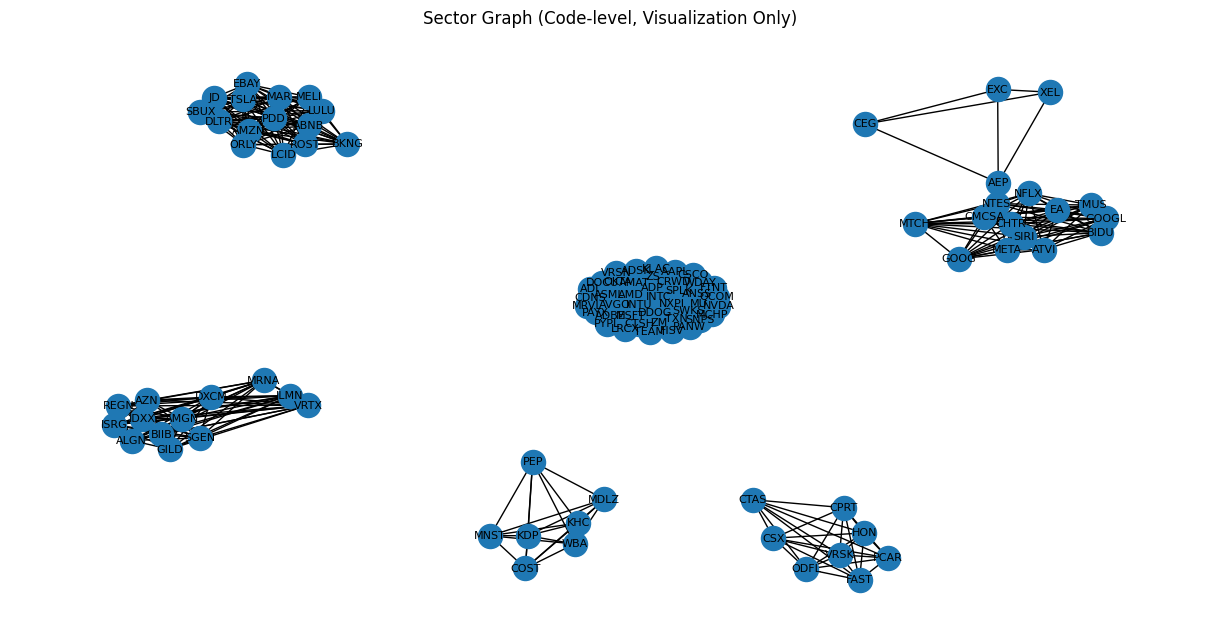

In [9]:
# ============================================================
# 10.1 SECTOR GRAPH (CODE-LEVEL) — VISUALIZATION ONLY
# ============================================================

stocks_code = (
    df_full
    .drop_duplicates(subset=["symbol"])
    .set_index("symbol")[["sector"]]
)

codes = stocks_code.index.to_list()
sectors = stocks_code["sector"].astype(str).values
N = len(codes)

# adjacency: 1 nếu cùng sector, 0 nếu khác
adj_sector = (
    (sectors[:, None] == sectors[None, :]) &
    (~np.eye(N, dtype=bool))
).astype(int)

G_sector_vis = nx.from_numpy_array(adj_sector)
G_sector_vis = nx.relabel_nodes(G_sector_vis, dict(enumerate(codes)))

plt.figure(figsize=(12, 6))
nx.draw(
    G_sector_vis,
    with_labels=True,
    node_size=300,
    font_size=8,
    pos=nx.spring_layout(G_sector_vis, seed=SEED, k=0.4)
)
plt.title("Sector Graph (Code-level, Visualization Only)")
plt.show()


In [10]:
print(adj_sector)

[[0 0 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 1]
 [1 0 1 ... 0 1 0]]


### **2️⃣ Cosine Similarity Graph**

- Edge giữa hai node nếu chúng có top-k độ tương đồng theo vector features
- Weight = cosine similarity

**Ý nghĩa:** Công ty có cấu trúc tài chính/hoạt động tương tự → cần truyền thông tin cho nhau.


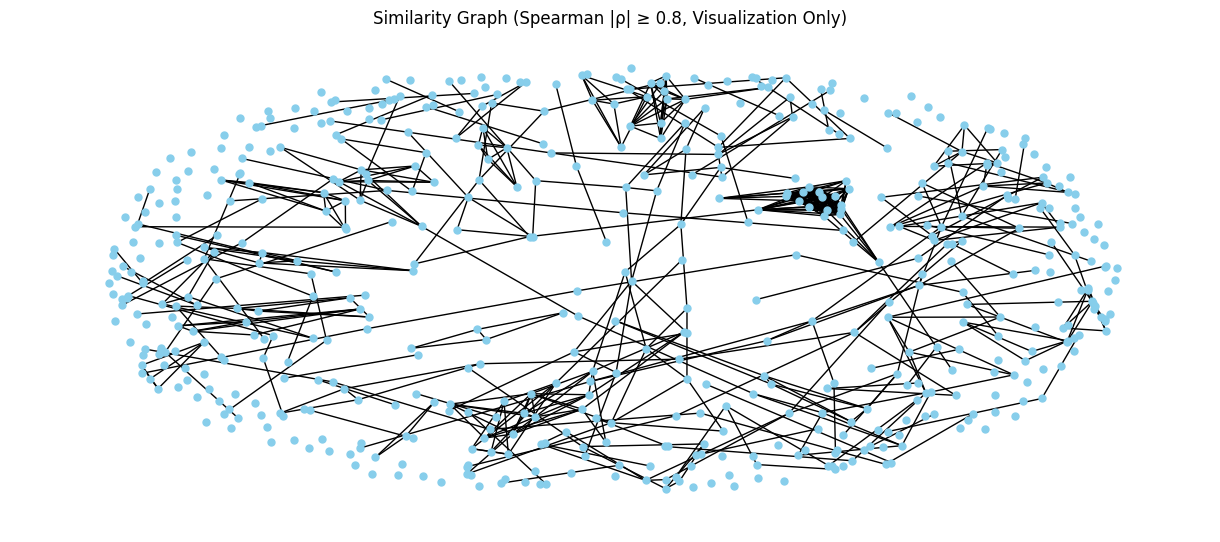

In [11]:
# ============================================================
# 10.2 SIMILARITY GRAPH (NODE-YEAR) — VISUALIZATION ONLY
# ============================================================

data_vis = df_full.reset_index(drop=True)

feature_cols = [
    c for c in data_vis.columns
    if c not in ["year", "y_distress", "symbol", "company", "sector", "subsector"]
    and pd.api.types.is_numeric_dtype(data_vis[c])
]

X_vis = (
    data_vis[feature_cols]
    .apply(pd.to_numeric, errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0.0)
    .values.astype(np.float32)
)

# scale for visualization only
X_vis = RobustScaler().fit_transform(X_vis)

# Spearman correlation between nodes
corr = pd.DataFrame(X_vis).T.corr(method="spearman").values
np.fill_diagonal(corr, 0.0)

corr_threshold = 0.8
adj_corr = (np.abs(corr) >= corr_threshold).astype(int)

G_corr_vis = nx.from_numpy_array(adj_corr)
G_corr_vis = nx.relabel_nodes(G_corr_vis, dict(enumerate(data_vis.index)))

plt.figure(figsize=(12, 5))
nx.draw(
    G_corr_vis,
    with_labels=False,
    node_size=25,
    node_color="skyblue",
    pos=nx.spring_layout(G_corr_vis, seed=SEED, k=0.25)
)
plt.title("Similarity Graph (Spearman |ρ| ≥ 0.8, Visualization Only)")
plt.show()


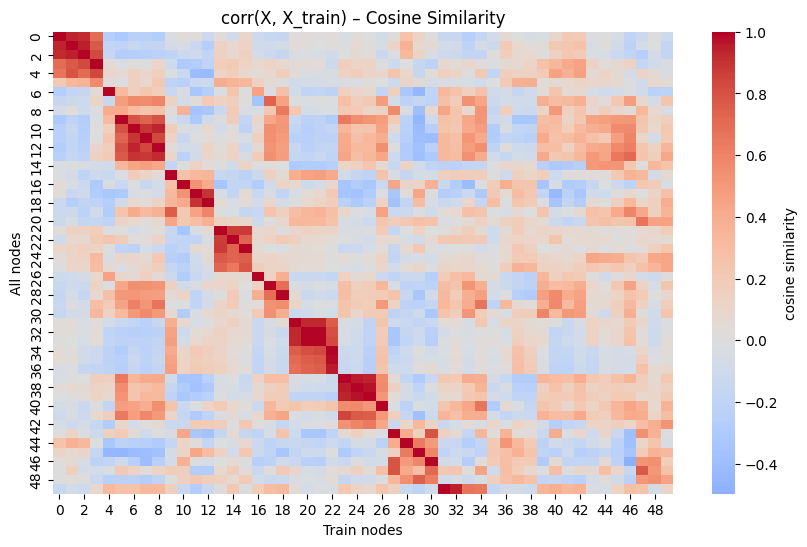

In [33]:
# ============================================================
# VISUALIZE corr(X, X_train)
# ============================================================

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# indices
train_idx = np.where(train_mask_np)[0]

# lấy sample cho dễ nhìn
n_show_nodes  = 50
n_show_train  = 50

X_show = X_all_scaled[:n_show_nodes]
Xtr_show = X_all_scaled[train_idx[:n_show_train]]

# corr(X, X_train)
corr_xt = cosine_similarity(X_show, Xtr_show)

plt.figure(figsize=(10,6))
sns.heatmap(
    corr_xt,
    cmap="coolwarm",
    center=0,
    cbar_kws={"label": "cosine similarity"}
)
plt.xlabel("Train nodes")
plt.ylabel("All nodes")
plt.title("corr(X, X_train) – Cosine Similarity")
plt.show()


In [34]:
# ============================================================
# STATISTICS OF corr(X, X_train)
# ============================================================

abs_corr = np.abs(corr_xt)

print("[corr(X, X_train) stats]")
print("Mean similarity   :", abs_corr.mean().round(4))
print("Median similarity :", np.median(abs_corr).round(4))
print("95% quantile      :", np.quantile(abs_corr, 0.95).round(4))
print("Max similarity    :", abs_corr.max().round(4))


[corr(X, X_train) stats]
Mean similarity   : 0.2078
Median similarity : 0.1494
95% quantile      : 0.6531
Max similarity    : 1.0


### **3️⃣ Merged Graph (Sector + Similarity)**

- Kết hợp trọng số graph theo công thức

**Ý nghĩa:**  
Graph vừa phản ánh cấu trúc ngành, vừa phản ánh sự tương đồng thực tế của dữ liệu tài chính.

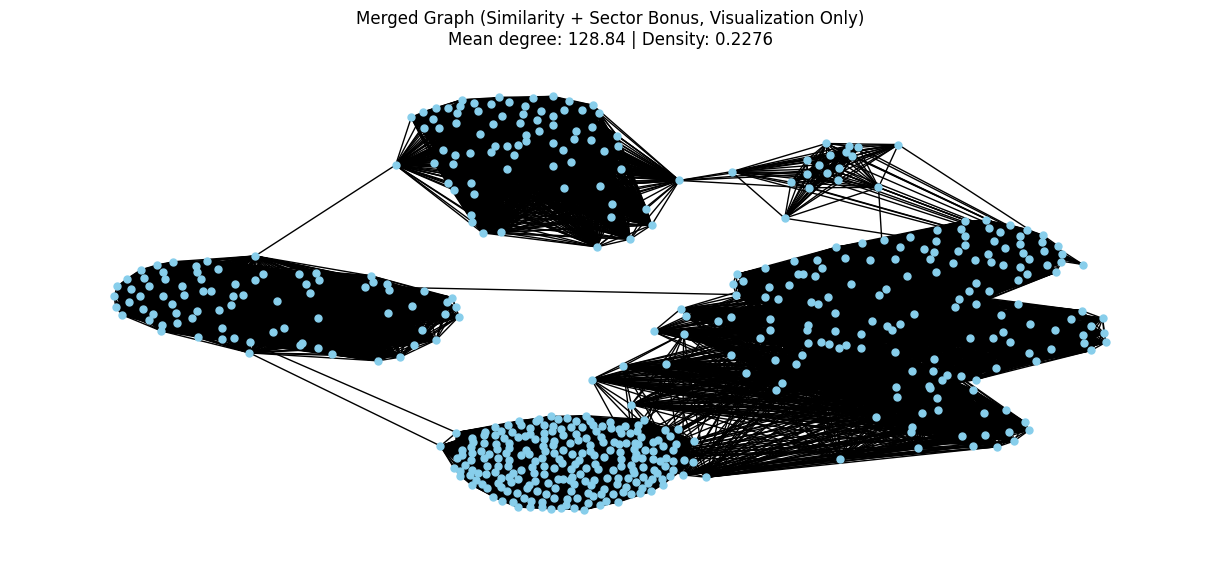

In [12]:
# ============================================================
# 10.3 MERGED GRAPH (SIMILARITY + SECTOR BONUS) — VISUALIZATION ONLY
# ============================================================

# map sector per node-year
sector_per_node = data_vis["sector"].astype(str).values
share_sector = (
    (sector_per_node[:, None] == sector_per_node[None, :]) &
    (~np.eye(len(sector_per_node), dtype=bool))
).astype(int)

sector_bonus = 0.05

adj_merge_vis = adj_corr.astype(float)
adj_merge_vis += share_sector * sector_bonus

# normalize only for plotting
if adj_merge_vis.max() > 0:
    adj_merge_vis = adj_merge_vis / adj_merge_vis.max()

G_merge_vis = nx.from_numpy_array(adj_merge_vis)
G_merge_vis = nx.relabel_nodes(G_merge_vis, dict(enumerate(data_vis.index)))

plt.figure(figsize=(12, 5))
nx.draw(
    G_merge_vis,
    with_labels=False,
    node_size=25,
    node_color="skyblue",
    pos=nx.spring_layout(G_merge_vis, seed=SEED, k=0.25)
)
plt.title(
    f"Merged Graph (Similarity + Sector Bonus, Visualization Only)\n"
    f"Mean degree: {np.mean([d for _, d in G_merge_vis.degree]):.2f} | "
    f"Density: {nx.density(G_merge_vis):.4f}"
)
plt.show()


## 11. GNN Model Architecture

| Model | Strength |
|------|----------|
| GCN | đơn giản, ổn định |
| GraphSAGE | tốt với sparse graph, inductive |
| GAT | attention mạnh giúp phát hiện điểm bất thường |

In [17]:
def build_sector_edges_temporal(df, train_mask, k_sector=3, w_sector=0.1):
    edges = []
    sectors = df["sector"].astype(str).values
    train_idx = np.where(train_mask)[0]

    sector_to_train = {}
    for s in np.unique(sectors):
        sector_to_train[s] = train_idx[sectors[train_idx] == s]

    for i in range(len(df)):
        s = sectors[i]
        cand = sector_to_train.get(s, np.array([], dtype=int))
        if cand.size == 0:
            continue

        if train_mask[i]:
            cand = cand[cand != i]

        if cand.size == 0:
            continue

        k = min(k_sector, cand.size)
        neigh = rng.choice(cand, size=k, replace=False)

        for j in neigh:
            edges.append((i, int(j), w_sector))
            edges.append((int(j), i, w_sector))

    return edges

def build_similarity_edges_to_train(X_all, train_mask, top_k=10, min_sim=0.0):
    train_idx = np.where(train_mask)[0]
    X_train = X_all[train_idx]

    sim = cosine_similarity(X_all, X_train)  # [N, N_train]

    edges = []
    for i in range(sim.shape[0]):
        row = sim[i].copy()

        if train_mask[i]:
            pos = np.where(train_idx == i)[0]
            if pos.size > 0:
                row[pos[0]] = -1.0

        k = min(top_k, row.shape[0])
        top_pos = np.argpartition(row, -k)[-k:]
        top_pos = top_pos[np.argsort(row[top_pos])]

        for p in top_pos:
            w = float(row[p])
            if w <= min_sim:
                continue
            j = int(train_idx[p])
            edges.append((i, j, w))
            edges.append((j, i, w))

    return edges

def edges_to_pyg(edges):
    d = {}
    for u, v, w in edges:
        key = (int(u), int(v))
        d[key] = max(d.get(key, -1e18), float(w))

    edge_index = np.array(list(d.keys()), dtype=np.int64).T
    edge_weight = np.array(list(d.values()), dtype=np.float32)
    return edge_index, edge_weight

In [18]:
K_SECTOR = 3
K_SIM    = 10

sector_edges = build_sector_edges_temporal(df_graph, train_mask_np, k_sector=K_SECTOR, w_sector=0.1)
sim_edges    = build_similarity_edges_to_train(X_all_scaled, train_mask_np, top_k=K_SIM, min_sim=0.0)

all_edges = sim_edges + sector_edges
edge_index_np, edge_weight_np = edges_to_pyg(all_edges)

print("N nodes:", len(df_graph))
print("Edges (directed):", edge_index_np.shape[1])

N nodes: 567
Edges (directed): 11900


In [19]:
data = Data(
    x=torch.tensor(X_all_scaled, dtype=torch.float32),
    y=torch.tensor(y_np, dtype=torch.long),
    edge_index=torch.tensor(edge_index_np, dtype=torch.long),
    edge_weight=torch.tensor(edge_weight_np, dtype=torch.float32),
    train_mask=torch.tensor(train_mask_np, dtype=torch.bool),
    val_mask=torch.tensor(val_mask_np, dtype=torch.bool),
    test_mask=torch.tensor(test_mask_np, dtype=torch.bool),
).to(device)

In [20]:
# -----------------------------
# Models
# -----------------------------
class GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F_torch.relu(x)
        x = F_torch.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x.squeeze(-1)

class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, dropout=0.2):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, 1)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index)
        x = F_torch.relu(x)
        x = F_torch.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze(-1)

class GAT(nn.Module):
    def __init__(self, in_dim, hidden_dim=32, heads=4, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim * heads, 1, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index)
        x = F_torch.elu(x)
        x = F_torch.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x.squeeze(-1)

## 12. Training

### Loss function: BCEWithLogitsLoss + pos_weight
### Optimizer: Adam
### Early stopping theo PR-AUC của Validation
* Mỗi epoch kiểm tra PR-AUC của tập Validation
* Nếu PR-AUC không tăng sau `patience` epochs → dừng
### Threshold tuning
* lấy xác suất trên Validation
* chọn threshold tốt nhất theo F1
* áp threshold đó lên Test

In [21]:
# -----------------------------
# Train/Eval with early stop + threshold tuning on VAL
# -----------------------------
def best_f1_threshold(y_true, probs):
    p, r, thr = precision_recall_curve(y_true, probs)
    f1 = 2 * p * r / (p + r + 1e-12)
    idx = int(np.nanargmax(f1[:-1]))
    return float(thr[idx]), float(f1[idx])

def eval_split(y_true, probs, threshold):
    y_pred = (probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    return {
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "PR-AUC": average_precision_score(y_true, probs),
        "Accuracy": acc,
        "CM": confusion_matrix(y_true, y_pred),
    }

def train_and_test(model, data, lr=0.005, epochs=400, patience=40, weight_decay=1e-4):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # pos_weight from TRAIN ONLY
    y_train = data.y[data.train_mask].detach().cpu().numpy()
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = torch.tensor([ (n_neg / max(n_pos, 1)) ], dtype=torch.float32, device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val_ap = -1.0
    best_state = None
    bad = 0

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()

        logits = model(data.x, data.edge_index, getattr(data, "edge_weight", None))
        loss = criterion(logits[data.train_mask], data.y[data.train_mask].float())

        loss.backward()
        optimizer.step()

        # Validate
        model.eval()
        with torch.no_grad():
            logits_val = model(data.x, data.edge_index, getattr(data, "edge_weight", None))
            probs_val = torch.sigmoid(logits_val[data.val_mask]).detach().cpu().numpy()
            y_val = data.y[data.val_mask].detach().cpu().numpy()
            val_ap = average_precision_score(y_val, probs_val)

        if val_ap > best_val_ap + 1e-5:
            best_val_ap = val_ap
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1

        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | TrainLoss {loss.item():.4f} | Val PR-AUC {val_ap:.4f} | best {best_val_ap:.4f}")

        if bad >= patience:
            print(f"Early stop at epoch {epoch} (best Val PR-AUC={best_val_ap:.4f})")
            break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    # Final inference
    model.eval()
    with torch.no_grad():
        logits_all = model(data.x, data.edge_index, getattr(data, "edge_weight", None))
        probs_all = torch.sigmoid(logits_all).detach().cpu().numpy()

    y_val = data.y[data.val_mask].detach().cpu().numpy()
    probs_val = probs_all[data.val_mask.detach().cpu().numpy()]
    thr, best_val_f1 = best_f1_threshold(y_val, probs_val)

    y_test = data.y[data.test_mask].detach().cpu().numpy()
    probs_test = probs_all[data.test_mask.detach().cpu().numpy()]

    val_metrics  = eval_split(y_val,  probs_val,  threshold=thr)
    test_metrics = eval_split(y_test, probs_test, threshold=thr)

    out = {
        "best_val_PR-AUC": best_val_ap,
        "tuned_threshold": thr,
        "val_F1@thr": val_metrics["F1"],
        "test_Precision": test_metrics["Precision"],
        "test_Recall": test_metrics["Recall"],
        "test_F1": test_metrics["F1"],
        "test_PR-AUC": test_metrics["PR-AUC"],
        "test_Accuracy": test_metrics["Accuracy"],
        "test_CM": test_metrics["CM"],
    }
    return out


In [22]:
# -----------------------------
# Run base GNN models
# -----------------------------
in_dim = data.x.size(1)

results_gnn = []
print("\n==============================")
print("GNN BASE GRAPH: train 3 models")
print("==============================")

for name, cls in [
    ("GCN", GCN),
    ("GraphSAGE", GraphSAGE),
    ("GAT", GAT),
]:
    print("\n==============================")
    print("Training:", name)
    model = cls(in_dim)
    res = train_and_test(model, data, lr=0.005, epochs=400, patience=40)
    res["Model"] = name
    res["Graph"] = "Baseline (Similarity-to-train + Sector-to-train)"
    res["Type"] = "GNN"
    results_gnn.append(res)


GNN BASE GRAPH: train 3 models

Training: GCN
Epoch 001 | TrainLoss 1.5136 | Val PR-AUC 0.2038 | best 0.2038
Early stop at epoch 45 (best Val PR-AUC=0.8854)

Training: GraphSAGE
Epoch 001 | TrainLoss 1.5622 | Val PR-AUC 0.2576 | best 0.2576
Epoch 050 | TrainLoss 0.1129 | Val PR-AUC 0.9769 | best 0.9769
Epoch 100 | TrainLoss 0.0199 | Val PR-AUC 0.9714 | best 0.9909
Early stop at epoch 111 (best Val PR-AUC=0.9909)

Training: GAT
Epoch 001 | TrainLoss 8.7815 | Val PR-AUC 0.5487 | best 0.5487
Epoch 050 | TrainLoss 0.5157 | Val PR-AUC 0.7113 | best 0.7113
Epoch 100 | TrainLoss 0.4620 | Val PR-AUC 0.7956 | best 0.7958
Epoch 150 | TrainLoss 0.3430 | Val PR-AUC 0.8817 | best 0.8985
Epoch 200 | TrainLoss 0.2914 | Val PR-AUC 0.9456 | best 0.9456
Early stop at epoch 236 (best Val PR-AUC=0.9456)


In [23]:
df_gnn = pd.DataFrame(results_gnn).sort_values(
    by=["test_F1", "test_PR-AUC"],
    ascending=False
).reset_index(drop=True)

print("\n=== GNN RESULTS (Test 2022) ===")
print(df_gnn[[
    "Model",
    "best_val_PR-AUC",
    "tuned_threshold",
    "val_F1@thr",
    "test_Precision",
    "test_Recall",
    "test_F1",
    "test_Accuracy",
    "test_PR-AUC"
]].round(4).to_string(index=False))

print("\n--- Confusion matrices (TEST 2022) ---")
for _, r in df_gnn.iterrows():
    print(f"\n{r['Model']} | thr={r['tuned_threshold']:.3f}")
    print(r["test_CM"])


=== GNN RESULTS (Test 2022) ===
    Model  best_val_PR-AUC  tuned_threshold  val_F1@thr  test_Precision  test_Recall  test_F1  test_Accuracy  test_PR-AUC
      GAT           0.9456           0.9284      0.9000           0.900       0.5625   0.6923         0.9216       0.7007
GraphSAGE           0.9909           0.3263      0.9524           0.625       0.6250   0.6250         0.8824       0.6899
      GCN           0.8854           0.6405      0.9000           0.750       0.3750   0.5000         0.8824       0.7017

--- Confusion matrices (TEST 2022) ---

GAT | thr=0.928
[[85  1]
 [ 7  9]]

GraphSAGE | thr=0.326
[[80  6]
 [ 6 10]]

GCN | thr=0.640
[[84  2]
 [10  6]]


## 13. Causal Feature Weights & Causal Graph Construction

### Ý tưởng
Một feature có ảnh hưởng mạnh tới distress thì:
- Các công ty giống nhau ở feature đó cần được kết nối mạnh hơn.
- Các feature yếu nên giảm trọng số để tránh nhiễu.

### Mục tiêu
- Ước lượng mức độ “nguyên nhân” (causal importance) của mỗi feature đối với distress.
- Dùng trọng số này để điều chỉnh cách xây dựng đồ thị (graph).
- Tạo ra **Causal Graph** mà trong đó cạnh (edge) phản ánh mức độ ảnh hưởng thật sự

In [24]:
# ============================================================
# 13.1 CAUSAL FEATURE WEIGHTS (PROXY using L1 Logistic Regression)
# ============================================================

from sklearn.linear_model import LogisticRegression
import numpy as np

def build_causal_feature_weights(X_train, y_train, eps=1e-6):
    """
    Proxy causal weights:
    Fit L1-regularized logistic regression on TRAIN ONLY.
    |coef| indicates feature importance to distress.
    Normalize so mean weight ≈ 1.
    """
    lr = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        C=0.5,
        max_iter=5000
    )
    lr.fit(X_train, y_train)

    w = np.abs(lr.coef_).reshape(-1)
    w = w + eps
    w = w / (w.mean() + eps)
    return w.astype(np.float32)


# compute causal weights from TRAIN data only
w_causal = build_causal_feature_weights(
    X_train_scaled,
    y_np[train_mask_np]
)

print("\n[CAUSAL FEATURE WEIGHTS]")
print("shape:", w_causal.shape)
print("min/mean/max:", w_causal.min(), w_causal.mean(), w_causal.max())



[CAUSAL FEATURE WEIGHTS]
shape: (40,)
min/mean/max: 3.2901082e-06 0.9999968 7.3084173


## 13.2 Causal-Weighted Similarity Edges

###
Ta muốn cosine similarity phản ánh mức độ giống nhau trên **các feature quan trọng nhất**.

Do đó:
1. Nhân feature vector với causal weight
2. Tính cosine(X, X_train)
3. Giữ top-k cạnh có similarity cao nhất

In [25]:
# ============================================================
# 13.2 CAUSAL-WEIGHTED SIMILARITY EDGES
# ============================================================

def build_similarity_edges_to_train_causal(
    X_all,
    train_mask,
    w_feat,
    top_k=15,          # increased
    min_sim=0.0
):
    train_idx = np.where(train_mask)[0]
    X_train = X_all[train_idx]

    # smoothed causal weights
    w_smooth = np.clip(w_feat, 0.5, 2.0)

    X_all_w   = X_all   * w_smooth
    X_train_w = X_train * w_smooth

    sim = cosine_similarity(X_all_w, X_train_w)

    edges = []
    for i in range(sim.shape[0]):
        row = sim[i].copy()

        if train_mask[i]:
            pos = np.where(train_idx == i)[0]
            if pos.size > 0:
                row[pos[0]] = -1.0

        k = min(top_k, row.shape[0])
        top_pos = np.argpartition(row, -k)[-k:]
        top_pos = top_pos[np.argsort(row[top_pos])]

        for p in top_pos:
            w_ij = float(row[p])
            j = int(train_idx[p])
            if w_ij > min_sim:
                edges.append((i, j, w_ij))
                edges.append((j, i, w_ij))

    return edges



# build causal similarity edges
K_SIM_CAUSAL = 10
causal_sim_edges = build_similarity_edges_to_train_causal(
    X_all_scaled,
    train_mask_np,
    w_feat=w_causal,
    top_k=K_SIM_CAUSAL
)


## 13.3 Sector-Based Causal Prior

### Lý do cần sector prior
Ngành (sector) là yếu tố tạo ra **mối quan hệ thực tế** giữa các công ty:

- các công ty trong cùng ngành chịu rủi ro giống nhau
- dễ lan truyền distress trong ngành
- phản ánh cấu trúc thị trường (market structure)

### Step
Đối với mỗi công ty:
1. Tìm các công ty trong cùng ngành thuộc tập TRAIN
2. Kết nối K_SECTOR công ty gần nhất
3. Trọng số = 0.2 (ưu tiên nhẹ nhưng chắc chắn)

In [26]:
# ============================================================
# 13.3 SECTOR PRIOR EDGES
# ============================================================

K_SECTOR = 3

sector_edges = build_sector_edges_temporal(
    df_graph,
    train_mask_np,
    k_sector=K_SECTOR,
    w_sector=0.2    # sector prior weight
)


## 13.4 Merged Causal Graph: Causal Similarity + Sector Prior

In [27]:
# ============================================================
# 13.4 MERGED CAUSAL GRAPH
# ============================================================

all_edges_causal = causal_sim_edges + sector_edges
edge_index_causal_np, edge_weight_causal_np = edges_to_pyg(all_edges_causal)

print("\n[CAUSAL GRAPH STATS]")
print("Nodes:", len(df_graph))
print("Edges (directed):", edge_index_causal_np.shape[1])



[CAUSAL GRAPH STATS]
Nodes: 567
Edges (directed): 12002


## 13.5 Build PyG Data Object

### Mục tiêu
Chuyển danh sách cạnh + feature matrix + mask thành `torch_geometric.data.Data`.

### Nội dung bao gồm:
- `x`: node features
- `y`: labels
- `edge_index`: danh sách cạnh (2 × E)
- `edge_weight`: trọng số cạnh
- `train_mask`, `val_mask`, `test_mask`

### Lưu ý:
Tất cả transformations (scaling, weighting, graph edges) đều được tính:
- chỉ từ TRAIN



In [28]:
# ============================================================
# 13.5 BUILD PYG DATA
# ============================================================

data_causal = Data(
    x=torch.tensor(X_all_scaled, dtype=torch.float32),
    y=torch.tensor(y_np, dtype=torch.long),
    edge_index=torch.tensor(edge_index_causal_np, dtype=torch.long),
    edge_weight=torch.tensor(edge_weight_causal_np, dtype=torch.float32),
    train_mask=torch.tensor(train_mask_np, dtype=torch.bool),
    val_mask=torch.tensor(val_mask_np, dtype=torch.bool),
    test_mask=torch.tensor(test_mask_np, dtype=torch.bool),
).to(device)


## 13.6 Training 

### Một số điểm chính:
- Loss: BCEWithLogitsLoss + pos_weight (xử lý imbalance)
- Optimizer: Adam
- Early stopping dựa trên Val PR-AUC
- Threshold tuning: chọn threshold tốt nhất theo F1 trên Validation

In [29]:
# ============================================================
# 13.6 TRAIN 3 GNN MODELS ON CAUSAL GRAPH
# ============================================================

results_causal_gnn = []

print("\n==============================")
print("CAUSAL-GNN: Training 3 models")
print("==============================")

for name, cls in [
    ("GCN", GCN),
    ("GraphSAGE", GraphSAGE),
    ("GAT", GAT),
]:
    print("\n==============================")
    print("Training:", name)

    model = cls(in_dim)
    res = train_and_test(
        model,
        data_causal,
        lr=0.005,
        epochs=400,
        patience=40
    )

    res["Model"] = name
    res["Graph"] = "Causal-weighted Similarity + Sector Prior"
    res["Type"]  = "Causal-GNN"
    results_causal_gnn.append(res)


CAUSAL-GNN: Training 3 models

Training: GCN
Epoch 001 | TrainLoss 1.1973 | Val PR-AUC 0.5998 | best 0.5998
Epoch 050 | TrainLoss 0.2796 | Val PR-AUC 0.8440 | best 0.8623
Epoch 100 | TrainLoss 0.2156 | Val PR-AUC 0.8642 | best 0.8881
Early stop at epoch 106 (best Val PR-AUC=0.8881)

Training: GraphSAGE
Epoch 001 | TrainLoss 1.4781 | Val PR-AUC 0.3687 | best 0.3687
Epoch 050 | TrainLoss 0.0871 | Val PR-AUC 0.8966 | best 0.8966
Epoch 100 | TrainLoss 0.0249 | Val PR-AUC 0.9417 | best 0.9417
Early stop at epoch 147 (best Val PR-AUC=0.9485)

Training: GAT
Epoch 001 | TrainLoss 3.0041 | Val PR-AUC 0.1804 | best 0.1804
Epoch 050 | TrainLoss 0.5480 | Val PR-AUC 0.8134 | best 0.8415
Early stop at epoch 81 (best Val PR-AUC=0.8415)


In [30]:
df_causal_gnn = pd.DataFrame(results_causal_gnn).sort_values(
    by=["test_F1", "test_PR-AUC"],
    ascending=False
).reset_index(drop=True)

print("\n=== CAUSAL-GNN RESULTS (Test 2022) ===")
print(df_causal_gnn[[
    "Model",
    "best_val_PR-AUC",
    "tuned_threshold",
    "val_F1@thr",
    "test_Precision",
    "test_Recall",
    "test_F1",
    "test_Accuracy",
    "test_PR-AUC"
]].round(4).to_string(index=False))



=== CAUSAL-GNN RESULTS (Test 2022) ===
    Model  best_val_PR-AUC  tuned_threshold  val_F1@thr  test_Precision  test_Recall  test_F1  test_Accuracy  test_PR-AUC
GraphSAGE           0.9485           0.9126      0.8889          0.8462       0.6875   0.7586         0.9314       0.7652
      GCN           0.8881           0.8400      0.9000          0.9091       0.6250   0.7407         0.9314       0.7395
      GAT           0.8415           0.7774      0.7778          0.6667       0.3750   0.4800         0.8725       0.6921


## 14. Final Leaderboard


In [176]:
def normalize_result_table1(df, model_type):
    """
    Chuẩn hóa tên cột cho ML / GNN / Causal-GNN
    Tự động rename sang format chuẩn
    """

    df = df.copy()

    # Step 1: đổi tên cột ML --> format GNN
    rename_map = {
        # ML metrics
        "Precision": "Test_Precision",
        "Recall": "Test_Recall",
        "F1": "Test_F1",
        "PR-AUC": "Test_PR-AUC",
        "Accuracy": "Test_Accuracy",
        "Threshold": "tuned_threshold",

        # GNN metrics
        "best_val_PR-AUC": "Val_PR-AUC",
        "tuned_threshold": "tuned_threshold",
        "val_F1@thr": "Val_F1@thr",
        "test_Precision": "Test_Precision",
        "test_Recall": "Test_Recall",
        "test_F1": "Test_F1",
        "test_PR-AUC": "Test_PR-AUC",
        "test_Accuracy": "Test_Accuracy",
    }

    for old, new in rename_map.items():
        if old in df.columns:
            df = df.rename(columns={old: new})

    # Step 2: thêm các cột bị thiếu
    required_cols = [
        "Model",
        "Val_PR-AUC",
        "Val_F1@thr",
        "Test_Precision",
        "Test_Recall",
        "Test_F1",
        "Test_Accuracy",
        "Test_PR-AUC",
        "tuned_threshold",
    ]

    for c in required_cols:
        if c not in df.columns:
            df[c] = np.nan

    # Step 3: gán loại mô hình
    df["Type"] = model_type

    # Step 4: giữ đúng thứ tự cột
    df = df[required_cols + ["Type"]]

    return df


In [177]:
df_ml_norm = normalize_result_table1(df_ml, "ML")
df_gnn_norm = normalize_result_table1(df_gnn, "GNN")
df_causal_norm = normalize_result_table1(df_causal_gnn, "Causal-GNN")


In [178]:
df_leaderboard = pd.concat([
    df_ml_norm,
    df_gnn_norm,
    df_causal_norm
], ignore_index=True)


In [179]:
df_leaderboard = df_leaderboard.sort_values(
    by=["Test_F1", "Test_PR-AUC"],
    ascending=False
).reset_index(drop=True)

print(df_leaderboard)


                  Model  Val_PR-AUC  Val_F1@thr  Test_Precision  Test_Recall  \
0             GraphSAGE    0.948485    0.888889        0.846154       0.6875   
1     Gradient Boosting    0.990909    0.952381        0.909091       0.6250   
2      Balanced Bagging    0.926241    0.869565        0.909091       0.6250   
3                   GCN    0.888068    0.900000        0.909091       0.6250   
4   Logistic Regression    0.910588    0.909091        0.785714       0.6875   
5         Random Forest    0.973333    0.909091        0.833333       0.6250   
6                   GAT    0.945556    0.900000        0.900000       0.5625   
7         Decision Tree    0.780029    0.777778        0.900000       0.5625   
8                   GAT    0.851293    0.761905        0.750000       0.5625   
9             GraphSAGE    0.990909    0.952381        0.625000       0.6250   
10            SVC (RBF)    1.000000    1.000000        0.875000       0.4375   
11                  GCN    0.885437    0

NOTE: INSIGHTS FROM LEADERBOARD (ML vs GNN vs Causal-GNN)

1. Causal-GNN đạt kết quả tốt nhất

- GraphSAGE (Causal-GNN) có Test_F1 cao nhất ~0.7586

- Precision cao (~0.85) và Recall ổn (~0.69)
=> causal weighting + sector prior giúp giảm nhiễu và chọn neighbor chính xác hơn.

1. ML truyền thống đứng top tiếp theo

-Gradient Boosting, Balanced Bagging, Logistic Regression đạt F1 ~0.73–0.74

- ML hoạt động rất ổn định vì không phụ thuộc cấu trúc graph
=> Với tabular data, ML baseline vẫn rất mạnh và khó bị vượt qua nếu graph chưa tối ưu.

3. Baseline GNN (không causal) kém nhất

- GCN baseline F1 chỉ 0.50–0.58

- GraphSAGE baseline ~0.69 (tốt hơn GCN nhưng vẫn thua ML)
=> cosine similarity + temporal restriction chưa đủ tốt → graph bị nhiễu nặng.

4. Causal graph cải thiện mạnh

- GraphSAGE từ 0.69 → 0.76 (+0.07 F1)

- GAT & GCN cũng tăng khi dùng causal graph
=> weighting feature theo causal importance giúp graph meaningful hơn.

5. Test PR-AUC: ML ~0.82–0.86 > Causal-GNN ~0.75
=> ML vẫn nhỉnh hơn về risk ranking, nhưng Causal-GNN có F1 cao hơn (cân bằng precision/recall).

6. Threshold khác biệt rõ

- Causal-GNN threshold cao (~0.91) → chỉ báo distress khi rất chắc chắn

- ML threshold thấp hơn (~0.2–0.6) → nhạy hơn với cảnh báo
=> Chọn mô hình tùy mục tiêu: ưu tiên precision hay recall.

FINAL SUMMARY

- Nếu cần phát hiện distress chính xác & ổn định → chọn Causal-GNN.

- Nếu muốn mô hình đơn giản, dễ triển khai → chọn ML (GBDT/RF).

- GNN chỉ vượt ML khi graph được xây “đúng” (causal + sector prior)